# **Фильтр Калмана для системы ДУ второго порядка**

## Филаткин Алексей

Построим фильтр Калмана для системы
 \begin{cases}
   \dot x(t) = \begin{pmatrix} 0 & 1\\ 1 & 0 \end{pmatrix}x(t) + \begin{pmatrix} 1\\ 0\end{pmatrix}u(t) + \widetilde{w}(t)\\
   z(t) = \begin{pmatrix} 1& 0\end{pmatrix}x(t) + v(t)
 \end{cases}
где $u(t)$ - внешнее воздействие, $w$ и $v$ - не коррелирующие между собой белые шумы с матрицей ковариции $Q =\begin{pmatrix} 3 & 0 \\ 0 & 3 \end{pmatrix}$ и дисперсией $R = 1$ соответственно, z(t) - измерение $x_{1}$

Белый шум моделируется нормальным распределением с нулевой медианой.

Внешнее воздействие также имеет нормальное распределение.

Тогда разностная схема в случае применения метода Эйлера для численного дифференцирования имеет вид
\begin{cases}
   x_{k} = Ax_{k-1} + Bu_{k} + w_{k}\\
   z_{k} = Hx_{k} + v_{k}
 \end{cases}
 где $A = \begin{pmatrix} 1 & \tau\\ \tau & 1 \end{pmatrix}$, $B = \begin{pmatrix} \tau\\ 0 \end{pmatrix}$, $H = \begin{pmatrix} 1 & 0 \end{pmatrix}$, w - белый шум с матрицей ковариации $Q =\begin{pmatrix} 3\tau^2 & 0 \\ 0 & 3\tau^2 \end{pmatrix}$, $\tau$ - шаг по времени

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# Инициализация
tau = 0.01
T = 3 # Суммарное время работы 
A = np.array([[1, tau], [tau, 1]])
B = np.array([tau, 0])
H = np.array([1, 0]).T
Q = np.array([[3 * tau ** 2, 0], [0, 3 * tau ** 2]])
R = 1
I = np.eye(2)
P = I
x = np.array([1, 1])
x_estimate = x
l = int(T / tau)
# Задание шумов и внешнего воздействия
u = np.random.normal(0, 1, l)
v = np.random.normal(0, 1, l)
w = tau*np.array([np.random.normal(0, 3**0.5, l), np.random.normal(0, 3**0.5, l)])
# Сюда будут записываться данные
x_plot1 = np.zeros((l, 2))
x_plot2 = np.zeros((l, 2))
z_plot = np.zeros(l)
z = x[0]

Фильтр Калмана - классический двухшаговый алгоритм предиктор-корректор, реализующийся на каждом такте управления.

1) Оценка вектора состояния x по модели
\begin{equation}
  \bar x_{k} = A x_{k-1} + B u_{k}
\end{equation}
Матрица ковариации ошибки оценивается следующим образом:
\begin{equation}
  \bar P_{k} = A \hat P_{k-1} A^{T} + Q
\end{equation}
где $\hat P_{k-1}$ - оценка матрицы ковариации ошибки с учётом коррекции на предыдущем шаге

2) Коррекция предсказания с учетом измерений

Матрица коррекции:
\begin{equation}
  \bar K_{k} = \bar P_{k} H^{T}(H \bar P_{k-1} H^{T} + R)^{-1}
\end{equation}
Оценка состояния:
\begin{equation}
  \hat x_{k} = \bar x_{k} + K_{k}(z_{k} - H \bar x_{k})
\end{equation}
Матрица ковариации ошибки с учётом коррекции:
\begin{equation}
  \hat P_{k} = (I - K_{k} H) \bar P_{k}
\end{equation}
Точное решение системы без внешнего воздействия и без шумов имеет вид
\begin{equation}
   x = C_{1} e^t \begin{pmatrix} 1 \\ 1 \end{pmatrix} + C_{2} e^{-t} \begin{pmatrix} 1 \\ -1 \end{pmatrix}
\end{equation}
Поэтому при несильных внешних воздействиях графики должны быть похоже на экспоненциальные

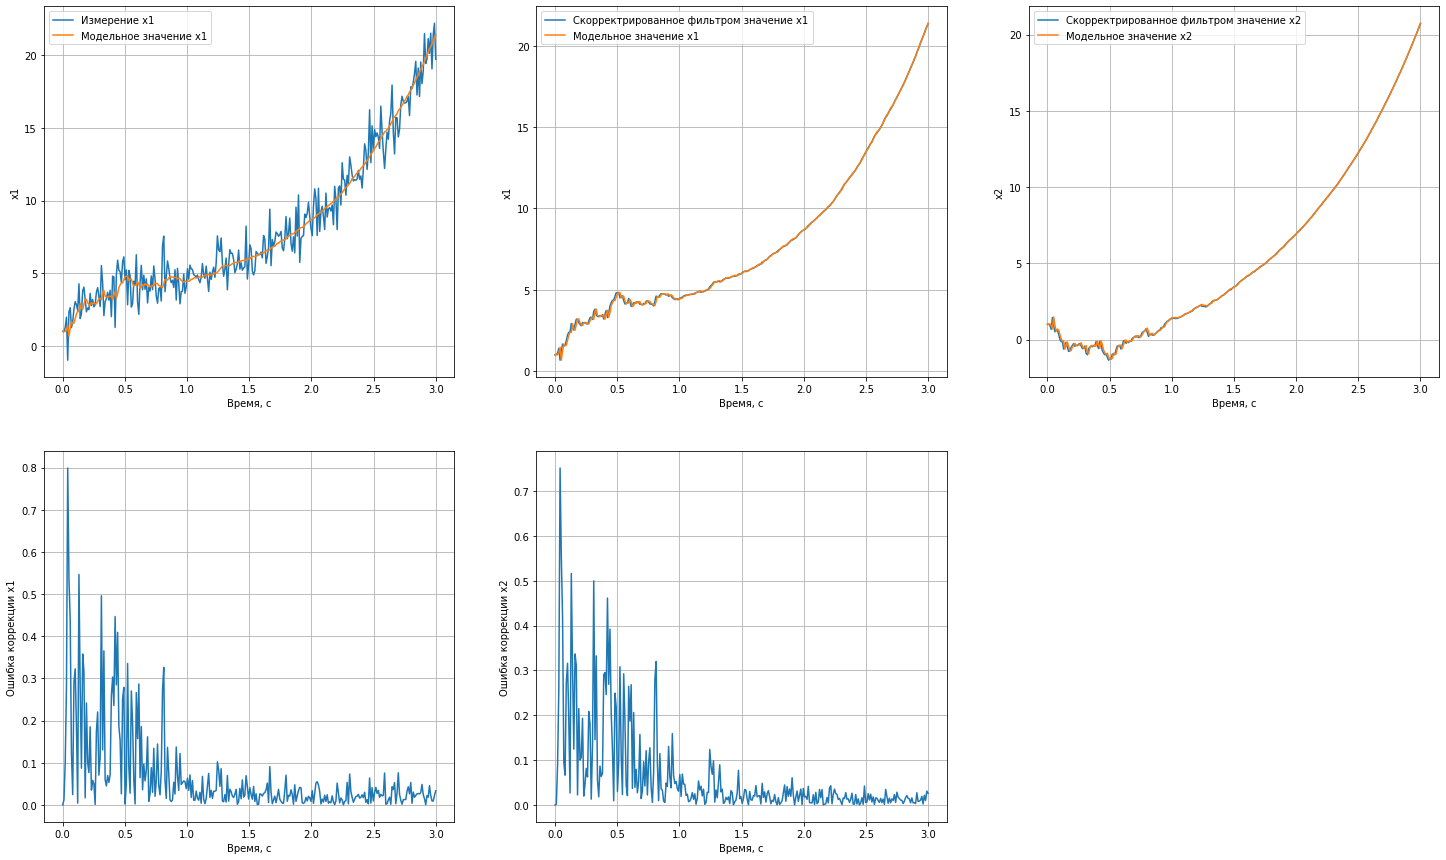

In [110]:
for i in range(l):
    # Сохраняем в массив данных
    x_plot1[i, :] = x_estimate
    x_plot2[i, :] = x
    z_plot[i] = z
    # Новый шаг процесса
    x = np.dot(A, x_estimate) + np.dot(B, u[i]) + w[:, i]
    # Измеряем вектор x
    z = np.dot(H, x) + v[i]
    # Предиктор
    x_predict = np.dot(A, x_estimate) + np.dot(B, u[i])
    P_predict = np.dot(A, np.dot(P, A.T)) + Q
    # Корректор
    K = np.dot(P_predict, H.T) / (np.dot(H, np.dot(P_predict, H.T)) + R)
    x_estimate = x_predict + np.dot(K, z - np.dot(H, x_predict))
    P = np.dot(I - np.dot(K, H), P_predict)
# Строим графики
t = np.linspace(0, T, l)
fig = plt.figure(figsize=(25, 15))

ax = fig.add_subplot(2, 3, 1)
ax.plot(t, z_plot, label='Измерение x1')
ax.plot(t, x_plot2[:, 0], label='Модельное значение x1')
ax.grid()
ax.legend()
ax.set_xlabel('Время, с')
ax.set_ylabel('x1')

ax = fig.add_subplot(2, 3, 2)
ax.plot(t, x_plot1[:, 0], label='Скорректрированное фильтром значение x1')
ax.plot(t, x_plot2[:, 0], label='Модельное значение x1')
ax.set_xlabel('Время, с')
ax.set_ylabel('x1')
ax.grid()
ax.legend()

ax = fig.add_subplot(2, 3, 3)
ax.plot(t, x_plot1[:, 1], label='Скорректрированное фильтром значение x2')
ax.plot(t, x_plot2[:, 1], label='Модельное значение x2')
ax.set_xlabel('Время, с')
ax.set_ylabel('x2')
ax.grid()
ax.legend()

ax = fig.add_subplot(2, 3, 4)
ax.plot(t, abs(x_plot1[:, 0] - x_plot2[:, 0]))
ax.set_xlabel('Время, с')
ax.set_ylabel('Ошибка коррекции x1')
ax.grid()

ax = fig.add_subplot(2, 3, 5)
ax.plot(t, abs(x_plot1[:, 1] - x_plot2[:, 1]))
ax.set_xlabel('Время, с')
ax.set_ylabel('Ошибка коррекции x2')
ax.grid()
plt.show()

Усилим шум модели $\widetilde{Q} = 100 Q$ а заодно для разнообразия зададим постоянное воздействие.

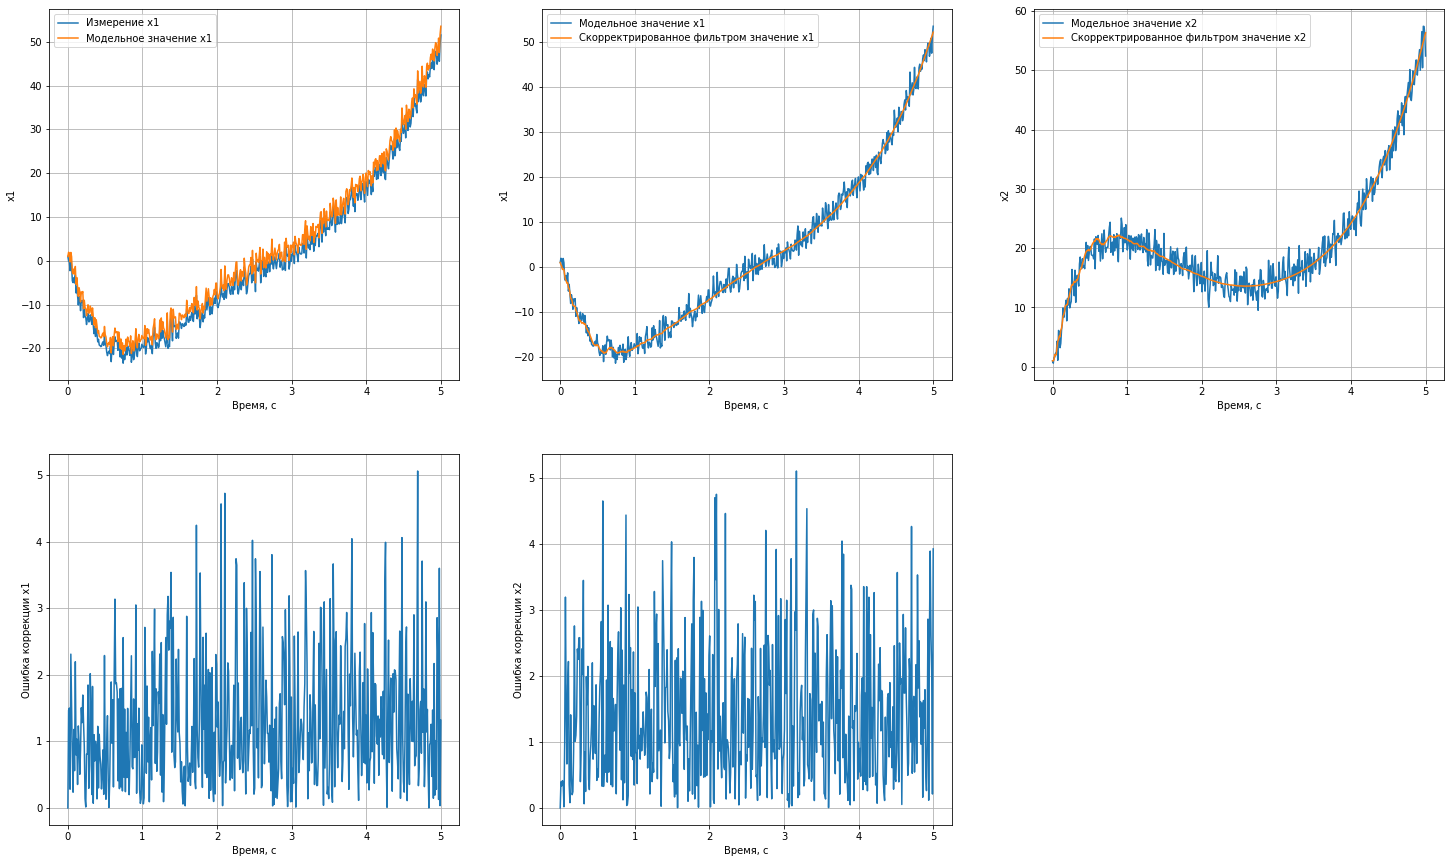

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Инициализация
tau = 0.01
T = 5 # Суммарное время работы 
A = np.array([[1, tau], [tau, 1]])
B = np.array([tau, 0])
H = np.array([1, 0]).T
Q = np.array([[3 * tau ** 2, 0], [0, 3 * tau ** 2]])
R = 1
I = np.eye(2)
P = I
x = np.array([1, 1])
x_estimate = x
l = int(T / tau)
# ИЗМЕНИЛИ ЗАДАНИЕ ШУМОВ И ВОЗДЕЙСТВИЯ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
u = np.random.normal(0, 1, l)
v = -2*np.ones(l)
w = 100*tau*np.array([np.random.normal(0, 3 ** 0.5, l), np.random.normal(0, 3 ** 0.5, l)])
# Сюда будут записываться данные
x_plot1 = np.zeros((l, 2))
x_plot2 = np.zeros((l, 2))
z_plot = np.zeros(l)
z = x[0]
for i in range(l):
    # Сохраняем в массив данных
    x_plot1[i, :] = x_estimate
    x_plot2[i, :] = x
    z_plot[i] = z
    # Новый шаг процесса
    x = np.dot(A, x_estimate) + np.dot(B, u[i]) + w[:, i]
    # Измеряем вектор x
    z = np.dot(H, x) + v[i]
    # Предиктор
    x_predict = np.dot(A, x_estimate) + np.dot(B, u[i])
    P_predict = np.dot(A, np.dot(P, A.T)) + Q
    # Корректор
    K = np.dot(P_predict, H.T) / (np.dot(H, np.dot(P_predict, H.T)) + R)
    x_estimate = x_predict + np.dot(K, z - np.dot(H, x_predict))
    P = np.dot(I - np.dot(K, H), P_predict)
# Строим графики
t = np.linspace(0, T, l)
fig = plt.figure(figsize=(25, 15))

ax = fig.add_subplot(2, 3, 1)
ax.plot(t, z_plot, label='Измерение x1')
ax.plot(t, x_plot2[:, 0], label='Модельное значение x1')
ax.grid()
ax.legend()
ax.set_xlabel('Время, с')
ax.set_ylabel('x1')

ax = fig.add_subplot(2, 3, 2)
ax.plot(t, x_plot2[:, 0], label='Модельное значение x1')
ax.plot(t, x_plot1[:, 0], label='Скорректрированное фильтром значение x1')
ax.set_xlabel('Время, с')
ax.set_ylabel('x1')
ax.grid()
ax.legend()

ax = fig.add_subplot(2, 3, 3)
ax.plot(t, x_plot2[:, 1], label='Модельное значение x2')
ax.plot(t, x_plot1[:, 1], label='Скорректрированное фильтром значение x2')
ax.set_xlabel('Время, с')
ax.set_ylabel('x2')
ax.grid()
ax.legend()

ax = fig.add_subplot(2, 3, 4)
ax.plot(t, abs(x_plot1[:, 0] - x_plot2[:, 0]))
ax.set_xlabel('Время, с')
ax.set_ylabel('Ошибка коррекции x1')
ax.grid()

ax = fig.add_subplot(2, 3, 5)
ax.plot(t, abs(x_plot1[:, 1] - x_plot2[:, 1]))
ax.set_xlabel('Время, с')
ax.set_ylabel('Ошибка коррекции x2')
ax.grid()
plt.show()

Эффективность фильтра теперь наглядна. Поскольку внешнее воздействие слабее экспоненциального, то естественно с ростом времени решение снова приходит к классическому виду.

Если шум модели сравним с ней самой(экспоненциальный по времени), то фильтр все равно отлично работает.

Если же шум сильнее решения, то, как и ожидается, точно установить значения нельзя и в среднем будет ноль(из начальных условий) 

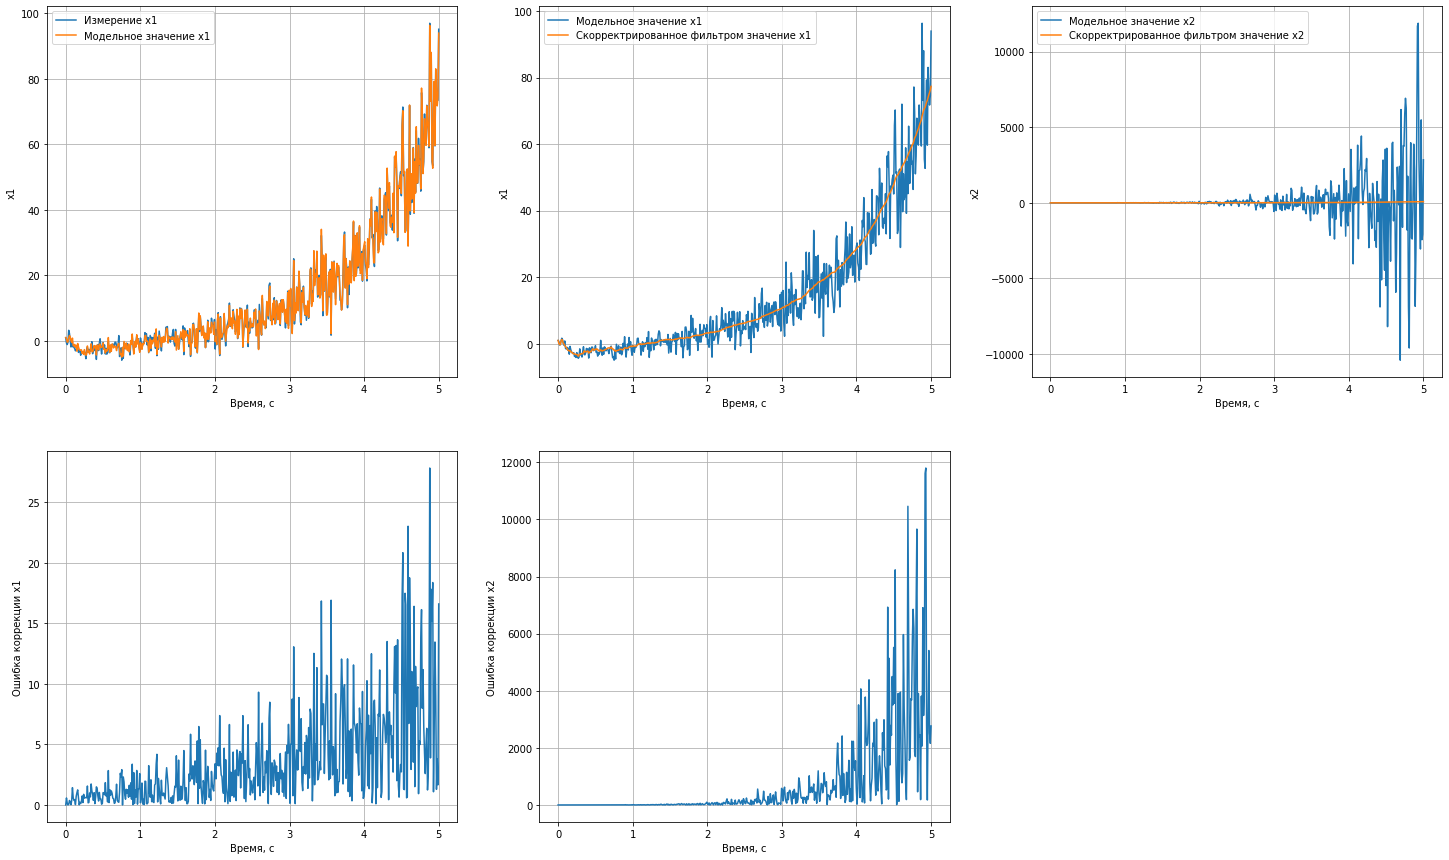

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Инициализация
tau = 0.01
T = 5 # Суммарное время работы 
A = np.array([[1, tau], [tau, 1]])
B = np.array([tau, 0])
H = np.array([1, 0]).T
Q = np.array([[3 * tau ** 2, 0], [0, 3 * tau ** 2]])
R = 1
I = np.eye(2)
P = I
x = np.array([1, 1])
x_estimate = x
l = int(T / tau)
# ИЗМЕНИЛИ ЗАДАНИЕ ШУМОВ И ВОЗДЕЙСТВИЯ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
t = np.linspace(0, T, l)
u = np.zeros((l, 2))
v = np.random.normal(0, 1, l)
w = np.array([np.exp(0.5*t) * np.random.normal(0, 1, l), t**2*np.exp(t) * np.random.normal(0, 3 ** 0.5, l)])
# Сюда будут записываться данные
x_plot1 = np.zeros((l, 2))
x_plot2 = np.zeros((l, 2))
z_plot = np.zeros(l)
z = x[0]
for i in range(l):
    # Сохраняем в массив данных
    x_plot1[i, :] = x_estimate
    x_plot2[i, :] = x
    z_plot[i] = z
    # Новый шаг процесса
    x = np.dot(A, x_estimate) + np.dot(B, u[i]) + w[:, i]
    # Измеряем вектор x
    z = np.dot(H, x) + v[i]
    # Предиктор
    x_predict = np.dot(A, x_estimate) + np.dot(B, u[i])
    P_predict = np.dot(A, np.dot(P, A.T)) + Q
    # Корректор
    K = np.dot(P_predict, H.T) / (np.dot(H, np.dot(P_predict, H.T)) + R)
    x_estimate = x_predict + np.dot(K, z - np.dot(H, x_predict))
    P = np.dot(I - np.dot(K, H), P_predict)
# Строим графики
fig = plt.figure(figsize=(25, 15))

ax = fig.add_subplot(2, 3, 1)
ax.plot(t, z_plot, label='Измерение x1')
ax.plot(t, x_plot2[:, 0], label='Модельное значение x1')
ax.grid()
ax.legend()
ax.set_xlabel('Время, с')
ax.set_ylabel('x1')

ax = fig.add_subplot(2, 3, 2)
ax.plot(t, x_plot2[:, 0], label='Модельное значение x1')
ax.plot(t, x_plot1[:, 0], label='Скорректрированное фильтром значение x1')
ax.set_xlabel('Время, с')
ax.set_ylabel('x1')
ax.grid()
ax.legend()

ax = fig.add_subplot(2, 3, 3)
ax.plot(t, x_plot2[:, 1], label='Модельное значение x2')
ax.plot(t, x_plot1[:, 1], label='Скорректрированное фильтром значение x2')
ax.set_xlabel('Время, с')
ax.set_ylabel('x2')
ax.grid()
ax.legend()

ax = fig.add_subplot(2, 3, 4)
ax.plot(t, abs(x_plot1[:, 0] - x_plot2[:, 0]))
ax.set_xlabel('Время, с')
ax.set_ylabel('Ошибка коррекции x1')
ax.grid()

ax = fig.add_subplot(2, 3, 5)
ax.plot(t, abs(x_plot1[:, 1] - x_plot2[:, 1]))
ax.set_xlabel('Время, с')
ax.set_ylabel('Ошибка коррекции x2')
ax.grid()
plt.show()

Действительно, вследствие слишком сильного шума $x_{2}$($\sim t^2 e^{t}$ ) коррекция невозможна

# **Выводы**

Фильтр Калмана довольно неплохо справляется  с определением значения переменных при корректной постановки задачи. С увеличением времени работы программы стабильность увеличивается.